In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
r1 =np.sqrt(0.33/np.pi)
r2 = np.sqrt((0.33/np.pi+r1**2))
r1, r2

(0.32410224072142874, 0.4583497844237541)

In [8]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [9]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [10]:
%%time
path_figs = './figs/2Mstd5/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 556 µs, sys: 664 µs, total: 1.22 ms
Wall time: 11.7 ms


In [11]:
%%time

N,D = 2*10**6, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 2
stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                  [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:1369, Number of Points:2000000
CPU times: user 1.4 s, sys: 293 ms, total: 1.69 s
Wall time: 1.96 s


In [12]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,0,0,4.275959,4.425694,0.149735
1,0.602763,0.544883,0,0,2.103205,2.792601,0.689397
2,0.423655,0.645894,2,0,-0.541712,0.881202,1.422914
3,0.437587,0.891773,0,1,2.707426,3.625753,-0.918327
4,0.963663,0.383442,0,0,-3.591661,0.860699,4.452360


In [13]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,4.997836e-01,5.001988e-01,1.141471e+00,5.001005e-01,1.199744e+00,1.202997e+00,1.140858e+00
std,2.887267e-01,2.886267e-01,1.719710e+00,5.000001e-01,2.306438e+00,2.305809e+00,3.309106e+00
min,1.637144e-07,2.516784e-08,0.000000e+00,0.000000e+00,-9.899472e+00,-8.476812e+00,-1.310288e+01
25%,2.495544e-01,2.502948e-01,0.000000e+00,0.000000e+00,-3.671571e-01,-3.631029e-01,-1.143762e+00
50%,4.999703e-01,5.003810e-01,0.000000e+00,1.000000e+00,1.110812e+00,1.112190e+00,1.026301e+00
75%,7.499998e-01,7.500191e-01,2.000000e+00,1.000000e+00,2.661313e+00,2.664783e+00,3.320841e+00
max,9.999993e-01,9.999997e-01,5.000000e+00,1.000000e+00,1.405698e+01,1.333605e+01,1.733285e+01


In [14]:
data['C'].value_counts()/len(data)

0    0.629252
5    0.078920
4    0.078807
3    0.078780
1    0.073178
2    0.061063
Name: C, dtype: float64

In [15]:
data.groupby('C').ITE.mean()

C
0    0.000275
1    0.992864
2    2.001573
3    2.995856
4    4.006582
5    4.992993
Name: ITE, dtype: float64

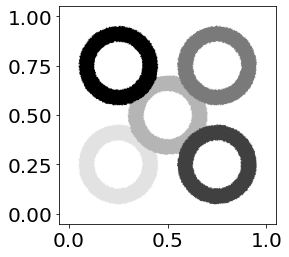

In [16]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [17]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [18]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 1h 3min 32s, sys: 1.65 s, total: 1h 3min 33s
Wall time: 1h 3min 33s


In [19]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,0,0,4.275959,4.425694,0.149735,1,1.413352,-2.862608
1,0.602763,0.544883,0,0,2.103205,2.792601,0.689397,0,0.897943,-1.205261
2,0.423655,0.645894,2,0,-0.541712,0.881202,1.422914,1,1.554407,2.096119
3,0.437587,0.891773,0,1,2.707426,3.625753,-0.918327,0,1.028318,1.679108
4,0.963663,0.383442,0,0,-3.591661,0.860699,4.452360,0,1.297068,4.888729


### Model performance

In [20]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        1.001207  1.003172  1.035370  0.001965  0.034163
            1        0.998424  0.990980  1.034986 -0.007444  0.036562
          1 0        0.005674  1.001663  1.003026  0.995989  0.997352
            1       -0.007149  1.026732  0.997042  1.033881  1.004191
          2 0       -0.011896  2.011886  1.968031  2.023783  1.979927
            1       -0.007714  1.994074  1.967468  2.001788  1.975182
          3 0        0.009091  2.995298  2.921096  2.986207  2.912005
            1       -0.026128  3.016039  2.921931  3.042167  2.948059
          4 0       -0.000337  4.009098  3.917220  4.009436  3.917557
            1        0.010243  3.978360  3.918788  3.968117  3.908546
          5 0        0.001670  5.014711  4.897097  5.013041  4.895427
            1        0.017147  4.985824  4.903702  4.968678  4.886556
1         0 0        1.001962  1.001159  0.962706  0.000802  0.039255
            1        1.001129  1.002038  0.963919 -0.000909  0.037211
          1 0        0.990822  0.004488  0.071966  0.986333  0.918855
            1        0.977287  0.011822  0.071439  0.965464  0.905848
          2 0        1.990214  0.005837  0.051769  1.984377  1.938446
            1        2.008839  0.027570  0.049935  1.981269  1.958904
          3 0        2.994797  0.002252  0.077010  2.992545  2.917787
            1        2.996481 -0.004113  0.077601  3.000594  2.918880
          4 0        4.008272 -0.000113  0.065610  4.008385  3.942662
            1        4.014349 -0.012065  0.061379  4.026413  3.952970
          5 0        4.991655  0.016580  0.061428  4.975074  4.930227
            1        5.003544 -0.004841  0.064670  5.008386  4.938875

### Apply clustering Box and Kmeans

In [21]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 19h 44min 19s, sys: 1h 42min 42s, total: 21h 27min 1s
Wall time: 1h 49min 1s


In [22]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,4.275959,4.425694,0.149735,1,1.413352,-2.862608,982,675
1,0.602763,0.544883,0,0,2.103205,2.792601,0.689397,0,0.897943,-1.205261,762,203
2,0.423655,0.645894,2,0,-0.541712,0.881202,1.422914,1,1.554407,2.096119,866,271
3,0.437587,0.891773,0,1,2.707426,3.625753,-0.918327,0,1.028318,1.679108,1200,1166
4,0.963663,0.383442,0,0,-3.591661,0.860699,4.452360,0,1.297068,4.888729,553,459


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [23]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [24]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.197434,1409.0,1.0,0.000705
1,1,-0.053910,1451.0,1.0,0.000726
2,2,0.040682,1399.0,1.0,0.000700


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


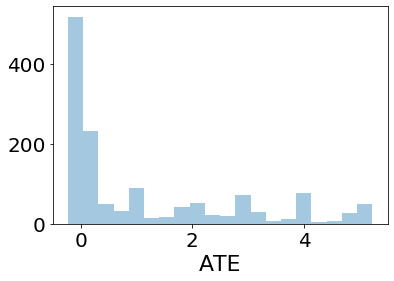

In [25]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 20
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, bins=bins, kde = False,ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


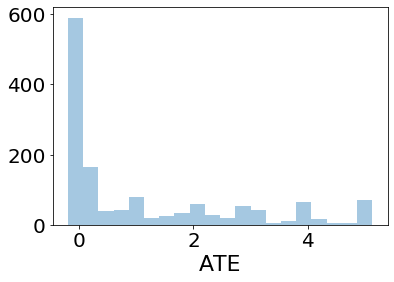

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], 
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


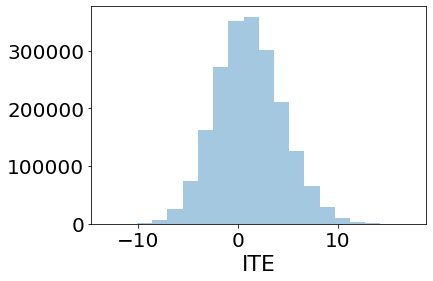

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = bins,
                  kde = kde, ax = ax)
ax.set_xlabel('ITE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [28]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,1369.00000,1369.000000,1369.000000,1369.000000,1369.000000
mean,684.00000,1.141747,1460.920380,0.940551,0.000730
std,395.34057,1.584437,37.097551,0.123603,0.000019
min,0.00000,-0.227384,1345.000000,0.486869,0.000673
25%,342.00000,0.000645,1435.000000,0.977417,0.000718
50%,684.00000,0.120956,1460.000000,1.000000,0.000730
75%,1026.00000,2.030774,1486.000000,1.000000,0.000743
max,1368.00000,5.220130,1590.000000,1.000000,0.000795


### Calculate ATT per Cluster not known Model Calculated CF

In [29]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


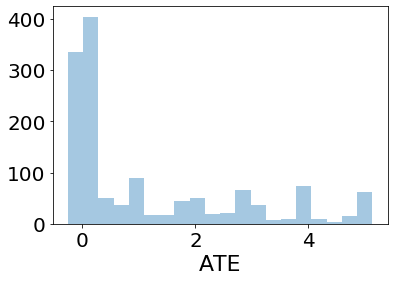

In [30]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'],bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-0.5,2.5)
if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


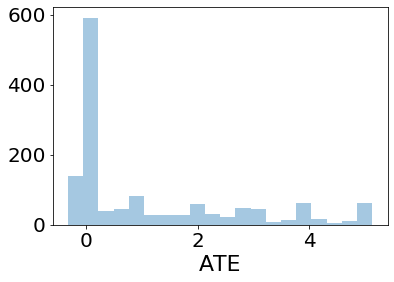

In [31]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], 
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-1,2.5)
if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


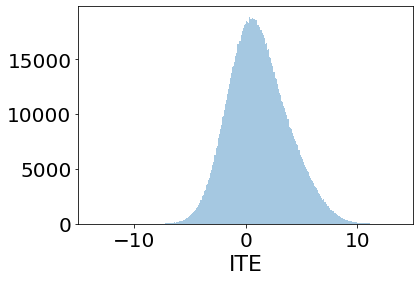

In [32]:
fig, ax = plt.subplots(1,1)
bins = 400
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ITE')
#ax.set_ylabel('weight')
ax.set_xlim(-15,15)
if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Optimal 3-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [33]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 7
val = 6
for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
    all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                      cluster_name = name, N=N, val = val )
    


CPU times: user 1.39 s, sys: 105 ms, total: 1.5 s
Wall time: 5.58 s


In [34]:
box['Box-Cl2'].value_counts()

0    786
1    153
3    130
2    126
4     93
5     81
Name: Box-Cl2, dtype: int64

In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.197434,1409.0,1.0,0.000705,0
1,1,-0.053910,1451.0,1.0,0.000726,0


In [36]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,4.275959,4.425694,0.149735,1,1.413352,-2.862608,982,675
1,0.602763,0.544883,0,0,2.103205,2.792601,0.689397,0,0.897943,-1.205261,762,203


### 3 Clustering in the ITEs

In [37]:
cluster_name1 = 'ITE-2CTrue'
col1 = 'ITE'
filt11 = data2[col1] <= 0.5
filt21 = data2[col1] >= 0.5
filt31 = data2[col1] >= 1.5
filt41 = data2[col1] >= 2.5
filt51 = data2[col1] >= 3.5
filt61 = data2[col1] >= 4.5

data2[cluster_name1] = 0
data2.loc[filt11,cluster_name1] = 0
data2.loc[filt21, cluster_name1] = 1
data2.loc[filt31, cluster_name1] = 2
data2.loc[filt41,cluster_name1] = 3
data2.loc[filt51, cluster_name1] = 4
data2.loc[filt61, cluster_name1] = 5

cluster_name2 = 'ITE-2CGDBR'
col2 = 'ITE-GDBR'
filt12 = data2[col2] <= 0.5
filt22 = data2[col2] >= 0.5
filt32 = data2[col2] >= 1.5
filt42 = data2[col2] >= 2.5
filt52 = data2[col2] >= 3.5
filt62 = data2[col2] >= 4.5


data2[cluster_name2] = 0
data2.loc[filt12,cluster_name2] = 0
data2.loc[filt22, cluster_name2] = 1
data2.loc[filt32, cluster_name2] = 2
data2.loc[filt42,cluster_name2] = 3
data2.loc[filt52, cluster_name2] = 4
data2.loc[filt62, cluster_name2] = 5


#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [38]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,0,0,4.275959,4.425694,0.149735,1,1.413352,-2.862608,982,675,0,0,2,1,2,1
1,0.602763,0.544883,0,0,2.103205,2.792601,0.689397,0,0.897943,-1.205261,762,203,1,0,1,1,1,1


### Plot reconstruction of data

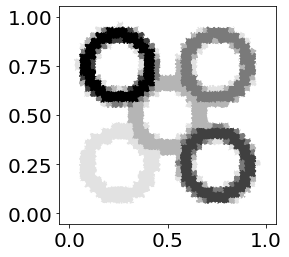

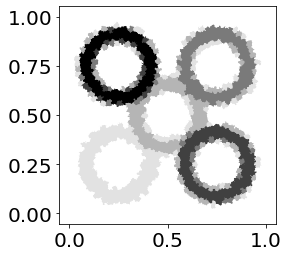

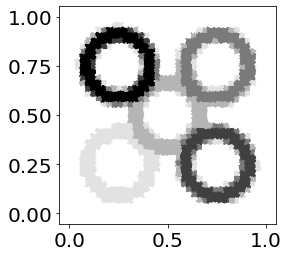

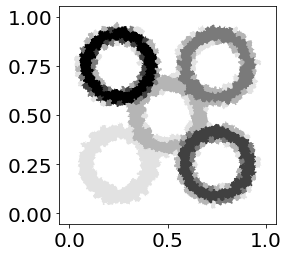

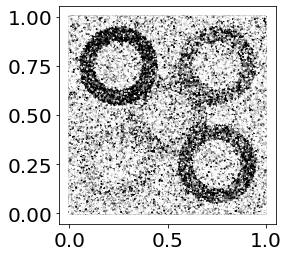

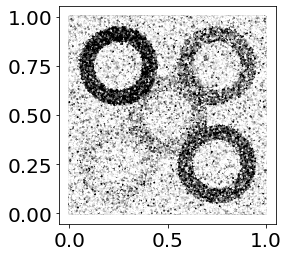

CPU times: user 9min 26s, sys: 17.2 s, total: 9min 43s
Wall time: 9min 24s


In [40]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [41]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [42]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [43]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [44]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [45]:
errors.sort_values(by = 'mean')

,mean,std
Box-Cl2-err-True-ITE,0.256060,0.635771
Box2-Cl2-err-True-ITE,0.261940,0.633955
Kmeans-Cl2-err-True-ITE,0.264681,0.645630
Kmeans2-Cl2-err-True-ITE,0.271091,0.643611
Box-Cl2-err-GDBR,0.274323,0.628554
Box2-Cl2-err-GDBR,0.278965,0.627070
Kmeans-Cl2-err-GDBR,0.281628,0.638840
Kmeans2-Cl2-err-GDBR,0.287134,0.637011
ITE-2CTrue-err-GDBR,1.407295,1.123113
ITE-2CGDBR-err-True-ITE,1.570694,0.999100


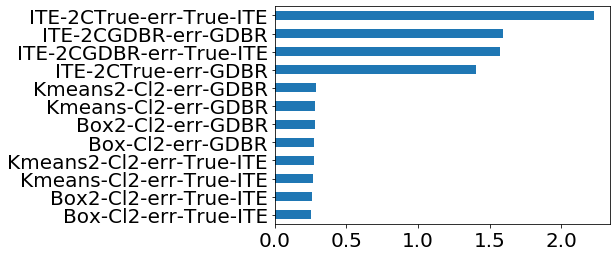

In [46]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [47]:
from evaluations import confusion_matrix
    

In [48]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)
for name in class_names2:
    mat = confusion_matrix(data2, 'C', name,6, save = True, save_dir = path4)
    print(name)
    display(mat)

Box-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.897947,0.052908,0.029698,0.015298,0.003499,0.000649
C1 True,0.080038,0.912733,0.007229,0.000000,0.000000,0.000000
C2 True,0.019611,0.066979,0.845620,0.061395,0.003226,0.003169
C3 True,0.016813,0.047696,0.155408,0.780082,0.000000,0.000000
C4 True,0.009143,0.024693,0.066942,0.158463,0.740759,0.000000
C5 True,0.004967,0.023118,0.044862,0.096047,0.087715,0.743291


Kmeans-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.880697,0.067183,0.037661,0.010157,0.004019,0.000282
C1 True,0.071230,0.924595,0.004175,0.000000,0.000000,0.000000
C2 True,0.011103,0.150769,0.773072,0.053641,0.011259,0.000156
C3 True,0.007261,0.074417,0.135917,0.782405,0.000000,0.000000
C4 True,0.003984,0.023012,0.117959,0.102998,0.752046,0.000000
C5 True,0.004910,0.020058,0.076432,0.062639,0.127053,0.708908


Box2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.888688,0.059698,0.032316,0.014768,0.003881,0.000649
C1 True,0.079990,0.910834,0.009176,0.000000,0.000000,0.000000
C2 True,0.017138,0.062279,0.846381,0.067806,0.003226,0.003169
C3 True,0.011964,0.048255,0.163329,0.776452,0.000000,0.000000
C4 True,0.007334,0.023215,0.070229,0.158463,0.740759,0.000000
C5 True,0.002908,0.022219,0.047821,0.089667,0.094095,0.743291


Kmeans2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.874847,0.067588,0.040616,0.012771,0.003896,0.000282
C1 True,0.055631,0.934085,0.010283,0.000000,0.000000,0.000000
C2 True,0.011103,0.128317,0.795524,0.053641,0.011259,0.000156
C3 True,0.004855,0.054456,0.166198,0.774491,0.000000,0.000000
C4 True,0.003984,0.020055,0.110574,0.121106,0.744280,0.000000
C5 True,0.003567,0.018240,0.065801,0.076432,0.127053,0.708908


ITE-2CTrue


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.570620,0.131384,0.109660,0.080188,0.052123,0.056025
C1 True,0.431858,0.139837,0.132178,0.110423,0.079594,0.106111
C2 True,0.298533,0.130880,0.139601,0.132665,0.108199,0.190122
C3 True,0.190068,0.108962,0.130967,0.141065,0.131995,0.296943
C4 True,0.107249,0.079955,0.110066,0.131232,0.139613,0.431884
C5 True,0.055290,0.053111,0.080499,0.110884,0.131868,0.568348


ITE-2CGDBR


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.589953,0.173006,0.122913,0.068719,0.030594,0.014815
C1 True,0.410239,0.196295,0.170912,0.118239,0.064309,0.040005
C2 True,0.236148,0.174368,0.194789,0.170634,0.116788,0.107274
C3 True,0.118343,0.124722,0.175921,0.193585,0.168489,0.218940
C4 True,0.046874,0.069892,0.123504,0.175828,0.193352,0.390549
C5 True,0.015756,0.033021,0.070876,0.125577,0.175361,0.579410


In [49]:
data2.groupby('ITE-2CGDBR').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.487653,0.485676,0.250792,0.500020,0.983625,0.990782,-1.200243,0.199519,0.978067,-1.237357,663.948732,680.203148,0.452345,0.373186,0.384082,0.383852,0.397995,0.208000,0.213934,0.213147,0.219923,1.040293,1.488149,0.193871,0.200993,0.200246,0.207821,1.978134,1.451035
1,0.495604,0.485571,0.659996,0.502757,1.054472,1.054840,0.970865,0.200911,1.049217,0.993691,664.102552,682.036281,1.370639,0.732436,0.735795,0.743354,0.751189,0.241638,0.246307,0.248202,0.254050,1.519024,1.091421,0.226189,0.232247,0.234085,0.240909,2.236382,1.081511
2,0.508428,0.493010,1.105724,0.500580,1.148561,1.145707,1.953438,0.200829,1.146181,1.980755,674.714554,683.177587,2.077286,1.118086,1.115879,1.128672,1.131742,0.272572,0.279907,0.278403,0.287808,1.817315,1.652485,0.254871,0.263830,0.262050,0.272705,2.468258,1.642310
3,0.525030,0.504642,1.778543,0.499132,1.318852,1.317971,2.940371,0.199791,1.324970,2.975009,691.253807,684.384275,2.843365,1.697975,1.690218,1.708416,1.706753,0.323259,0.329180,0.328623,0.335425,1.994808,1.880415,0.302019,0.309642,0.308711,0.316907,2.629627,1.872452
4,0.532885,0.522952,2.572689,0.497900,1.544188,1.555373,3.950104,0.199566,1.561362,3.970296,716.663158,683.965693,3.578286,2.387115,2.370863,2.396864,2.386270,0.378439,0.389783,0.381528,0.393757,1.934308,1.798024,0.352901,0.365907,0.357230,0.370919,2.622974,1.793821
5,0.497376,0.564919,3.727290,0.498576,1.948785,1.946666,5.914319,0.200118,1.972822,5.944096,772.746139,680.153283,4.467760,3.393324,3.361735,3.402080,3.375608,0.461793,0.476471,0.460895,0.474656,1.308691,2.216806,0.430715,0.446170,0.430758,0.445222,2.263996,2.187029


In [50]:
np.mean(np.abs(data2['C'] - data2['ITE-GDBR'])), np.std(np.abs(data2['C'] - data2['ITE-GDBR']))

(1.630751578832622, 1.233844602209737)